In [27]:
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, add_source
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from svgpath2mpl import parse_path
from scipy.interpolate import interp1d

In [9]:
df = pd.read_csv("teams.csv",index_col=[0])
df.columns = df.columns.astype(int)
df

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
team,,,,,,,,,,,,,,,
Boston Breakers,BOS,BOS,BOS,BOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FC Kansas City,KC,KC,KC,KC,UTA,UTA,UTA,UTA,KCC,KCC,KCC,KCC,KCC,KCC,KCC
Chicago Red Stars,CHI,NaN,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI,CHI
Portland Thorns,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR,POR
Seattle Reign,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN,RGN
Sky Blue FC,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY,NJNY
Washington Spirit,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS
Western New York Flash,WNY,WNY,WNY,WNY,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC
Houston Dash,NaN,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU


In [10]:
# Gather the list of cities for the y-axis
cities = pd.read_csv("cities.csv")


def city_to_y(c):
    if c == "KCC":
        c = "KC"
    elif c == "B2":
        c = "BOS"
    return cities[cities["city"] == c].index[0]


cities

,city,name
0,CHI,Chicago
1,POR,Portland
2,RGN,Seattle
3,NJNY,New Jersey
4,WAS,Washington DC
5,BOS,Boston
6,KC,Kansas City
7,UTA,Salt Lake City
8,WNY,Rochester
9,NC,"Cary, NC"


In [11]:
# Gather the list of years for the x-axis
years = df.columns
years

Int64Index([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
            2024, 2025, 2026, 2027],
           dtype='int64')

In [12]:
# Gather name labels
names = pd.read_csv("names.csv")
names["city_index"] = names["city"].apply(city_to_y)
names

,city,year,name,city_index
0,BOS,2013,Boston Breakers,5
1,KC,2013,FC Kansas City,6
2,CHI,2013,Chicago Red Stars,0
3,POR,2013,Portland Thorns,1
4,RGN,2013,Seattle Reign,2
5,NJNY,2013,Sky Blue FC,3
6,WAS,2013,Washington Spirit,4
7,WNY,2013,Western New York Flash,8
8,HOU,2014,Houston Dash,10
9,ORL,2016,Orlando Pride,11


In [15]:
winners = pd.read_csv("winners.csv")
winners

,year,champion,shield,challenge_cup,fall_series
0,2013,POR,WNY,NaN,NaN
1,2014,KC,RGN,NaN,NaN
2,2015,KC,RGN,NaN,NaN
3,2016,WNY,POR,NaN,NaN
4,2017,POR,NC,NaN,NaN
5,2018,NC,NC,NaN,NaN
6,2019,NC,NC,NaN,NaN
7,2020,NaN,NaN,HOU,POR
8,2021,WAS,POR,POR,NaN
9,2022,POR,RGN,NC,NaN


In [59]:
shield_d = "M -0 -318 q 112 28 184 130 T 256 35.6 V 226 l -256 96 l -256 -96 v -190.4 q -0 -121.6 72 -223.6 T -0 -318 Z m 0 49.6 q -92 30.4 -150 114.8 T -208 35.6 V 192.4 l 208 78.4 l 208 -78.4 v -156.8 q -0 -104.8 -58 -189.2 T -0 -268.4 Z m 0 269.6 Z"
shield_path = parse_path(shield_d)
shield_path = shield_path.transformed(mpl.transforms.Affine2D())

trophy_d = "M -400 800 v -160 h 320 v -248 q -98 -22 -175 -83 T -368 156 q -150 -18 -251 -131 T -720 -240 v -80 q 0 -66 47 -113 T -560 -480 h 160 v -160 h 800 v 160 h 160 q 66 0 113 47 T 720 -320 v 80 q 0 152 -101 265 T 368 156 q -36 92 -113 153 T 80 392 v 248 h 320 v 160 H -400 Z m 0 -816 v -304 h -160 v 80 q 0 76 44 137 t 116 87 Z m 400 256 q 100 0 170 -70 t 70 -170 v -480 H -240 v 480 q 0 100 70 170 t 170 70 Z m 400 -256 q 72 -26 116 -87 t 44 -137 v -80 h -160 v 304 Z m -400 -104 Z"
trophy_path = parse_path(trophy_d)
trophy_path = trophy_path.transformed(mpl.transforms.Affine2D().rotate_deg(180))

In [60]:
# Helpers to interpolate lines as curves
def interpolate_base(cubic_p):
    x1 = 0
    y1 = 0
    x2 = 1
    y2 = 1
    steps = np.linspace(0, cubic_p, 10)
    x = list(map(lambda i: x1 + i, steps)) + list(map(lambda i: x2 - i, steps[::-1]))
    y = [y1] * len(steps) + [y2] * len(steps)
    f = interp1d(x, y, kind="quadratic")
    xs = np.linspace(x1, x2, num=40)
    ys = f(xs)

    return (xs, ys)


def interpolate(x1, y1, x2, y2):
    (xs, ys) = interpolate_base(0.1)
    for i in range(0, len(xs)):
        xs[i] = x1 + xs[i] * (x2 - x1)
        ys[i] = y1 + ys[i] * (y2 - y1)

    return (xs, ys)


def to_points(x, y):
    c = list(map(lambda a: NWSL.color(a), y))
    y = list(map(city_to_y, y))

    x2, y2, c2 = [], [], []
    for xi, yi, ci in zip(x, y, c):
        if len(x2) == 0:
            x2.append(xi)
            y2.append(yi)
            c2.append(ci)
        else:
            xs, ys = interpolate(x2[-1], y2[-1], xi, yi)
            x2.extend(xs)
            y2.extend(ys)
            c2.extend([ci if i > len(xs) * 0.5 else c2[-1] for i in range(0, len(xs))])
    return (x2, y2, c2)

<Figure size 9600x6000 with 0 Axes>

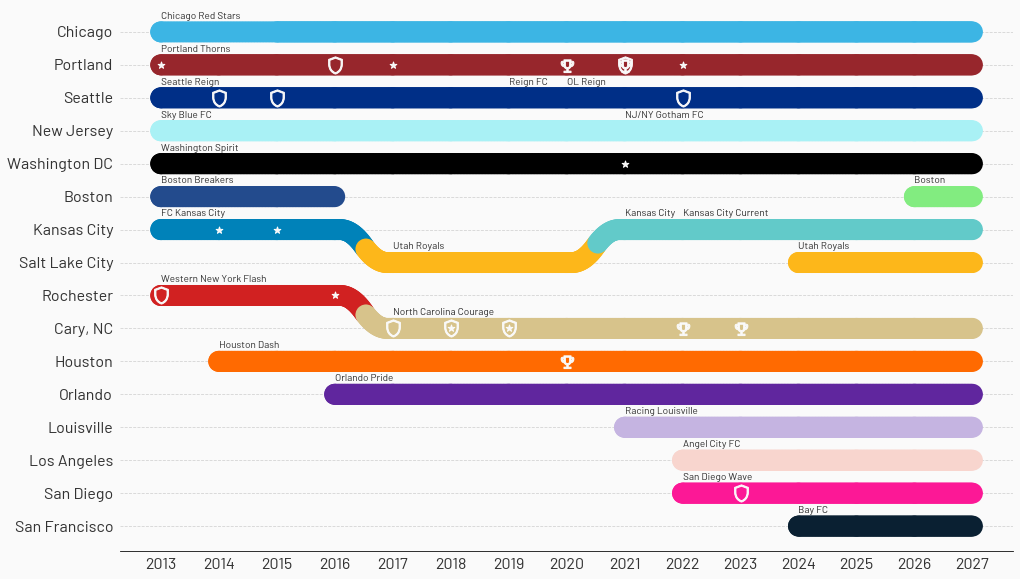

In [61]:
# Setup
plt.rcParams["figure.figsize"] = (16, 10)
plt.figure(dpi=600)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot data
for i, row in df.iterrows():
    row = row.dropna()
    x, y, c = to_points(row.index, row.values)
    ax.scatter(x, y, color=c, lw=15)

# Add team names
for i, row in names.iterrows():
    ax.text(
        row["year"],
        row["city_index"] - 0.4,
        row["name"],
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
    )

# TODO: add champion, shield, and cup winners
champion = winners[["year", "champion"]].dropna()
ax.scatter(
    champion["year"],
    list(map(city_to_y, champion["champion"])),
    color=Colors.WHITE,
    marker="*",
    s=50,
)

shield = winners[["year", "shield"]].dropna()
ax.scatter(
    shield["year"],
    list(map(city_to_y, shield["shield"])),
    color=Colors.WHITE,
    marker=shield_path,
    s=300,
)

trophy = winners[["year", "challenge_cup"]].dropna()
ax.scatter(
    trophy["year"],
    list(map(city_to_y, trophy["challenge_cup"])),
    color=Colors.WHITE,
    marker=trophy_path,
    s=200,
)

trophy = winners[["year", "fall_series"]].dropna()
ax.scatter(
    trophy["year"],
    list(map(city_to_y, trophy["fall_series"])),
    color=Colors.WHITE,
    marker=trophy_path,
    s=200,
)

# Add axes
ax.spines[["top", "right", "left"]].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)


ax.set_xticks(years)
ax.set_xticklabels(
    years,
    fontproperties=Fonts.BARLOW,
    size=16,
    color=Colors.BLACK,
)

ax.set_yticks(cities.index)
ax.set_yticklabels(
    cities["name"],
    fontproperties=Fonts.BARLOW,
    size=16,
    color=Colors.BLACK,
)
ax.invert_yaxis()
ax.yaxis.grid(True, color=Colors.LIGHT_GRAY, linestyle="--")